In [1]:
import numpy as np

class Embedding:
    def __init__(self, w):
        self.params = [w]
        self.grads = [np.zeros_like(w)]
        self.idx = None
    def forward(self, idx):
        self.idx = idx
        return self.params[0][idx]
    def backward(self, dout):
        self.grads[0][...] = 0
        np.add.at(self.grads[0], self.idx, dout)
        return None

In [2]:
class EmbeddingDot:
    def __init__(self, w):
        self.embed = Embedding(w)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    def forward(self, h, idx):
        target_w = self.embed.forward(idx)
        out = np.sum(target_w*h, axis=1)
        self.cache = (h, target)
        return out
    def backward(self, dout):
        h, target_w = self.cache
        self.embed.backward(h*dout)
        return target_w*dout

In [3]:
import collections
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        return negative_sample

In [4]:
import numpy as np
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
negative_sample

array([[3, 0],
       [1, 2],
       [1, 2]])

In [5]:
from common.layers import SigmoidWithLoss

class NegativeSamplingLoss:
    def __init__(self, w, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size+1)]
        self.embed_dot_layers = [EmbeddingDot(w) for _ in range(sample_size+1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += [layer.params]
            self.grads += [layer.grads]
    def forward(self, h, target):
        batch_size = len(target)
        negative_sample = self.sampler.get_negative_sample(target)
        
        positive_target = np.ones_like(target, dtype=np.int32)
        score = self.embed_dot_layers[0].forward(h, target)
        loss = self.loss_layers[0].forward(score, positive_target)
        
        negative_target = np.zeros_like(negative_sample, dtype=np.int32)
        for i in range(self.sample_size):
            score = self.embed_dot_layers[i+1].forward(h, negative_sample[:, i])
            loss += self.loss_layers[i+1].forward(score, negative_target[:, i])
        return loss
    def backward(self, dout=1):
        dh = 0
        for i in range(self.sample_size+1):
            dscore = self.loss_layers[i].backward(dout)
            dh += self.embed_dot_layers[i].backward(dscore)
            
        return dh

In [3]:
from common.np import *
from common.layers import Embedding
from common.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        w_in = np.random.randn(vocab_size, hidden_size).astype('f')
        w_out = np.random.randn(vocab_size, hidden_size).astype('f')
        
        self.in_layers = []
        for _ in range(2*window_size):
            self.in_layers += [Embedding(w_in)]
        self.ns_loss = NegativeSamplingLoss(w_out, corpus)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = w_in
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1/len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    def backward(self, dout=1):
        dh = self.ns_loss.backward(dout)
        dh *= 1/len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dh)
        return None

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 9.06
| 에폭 1 |  반복 21 / 9295 | 시간 3[s] | 손실 9.40
| 에폭 1 |  반복 41 / 9295 | 시간 6[s] | 손실 9.13
| 에폭 1 |  반복 61 / 9295 | 시간 9[s] | 손실 8.97
| 에폭 1 |  반복 81 / 9295 | 시간 12[s] | 손실 8.92
| 에폭 1 |  반복 101 / 9295 | 시간 15[s] | 손실 8.72
| 에폭 1 |  반복 121 / 9295 | 시간 19[s] | 손실 8.79
| 에폭 1 |  반복 141 / 9295 | 시간 22[s] | 손실 8.80
| 에폭 1 |  반복 161 / 9295 | 시간 25[s] | 손실 8.53
| 에폭 1 |  반복 181 / 9295 | 시간 28[s] | 손실 8.55
| 에폭 1 |  반복 201 / 9295 | 시간 31[s] | 손실 8.71
| 에폭 1 |  반복 221 / 9295 | 시간 34[s] | 손실 8.52
| 에폭 1 |  반복 241 / 9295 | 시간 37[s] | 손실 8.36
| 에폭 1 |  반복 261 / 9295 | 시간 40[s] | 손실 8.25
| 에폭 1 |  반복 281 / 9295 | 시간 43[s] | 손실 8.20
| 에폭 1 |  반복 301 / 9295 | 시간 47[s] | 손실 8.38
| 에폭 1 |  반복 321 / 9295 | 시간 50[s] | 손실 8.20
| 에폭 1 |  반복 341 / 9295 | 시간 53[s] | 손실 8.14
| 에폭 1 |  반복 361 / 9295 | 시간 56[s] | 손실 8.35
| 에폭 1 |  반복 381 / 9295 | 시간 59[s] | 손실 8.05
| 에폭 1 |  반복 401 / 9295 | 시간 62[s] | 손실 7.97
| 에폭 1 |  반복 421 / 9295 | 시간 66[s] | 손실 7.99
| 에폭 1 |  반복 441 / 9

| 에폭 1 |  반복 3541 / 9295 | 시간 544[s] | 손실 4.17
| 에폭 1 |  반복 3561 / 9295 | 시간 547[s] | 손실 4.18
| 에폭 1 |  반복 3581 / 9295 | 시간 551[s] | 손실 4.10
| 에폭 1 |  반복 3601 / 9295 | 시간 554[s] | 손실 4.16
| 에폭 1 |  반복 3621 / 9295 | 시간 557[s] | 손실 4.17
| 에폭 1 |  반복 3641 / 9295 | 시간 560[s] | 손실 4.17
| 에폭 1 |  반복 3661 / 9295 | 시간 563[s] | 손실 4.16
| 에폭 1 |  반복 3681 / 9295 | 시간 566[s] | 손실 4.19
| 에폭 1 |  반복 3701 / 9295 | 시간 569[s] | 손실 4.11
| 에폭 1 |  반복 3721 / 9295 | 시간 572[s] | 손실 4.18
| 에폭 1 |  반복 3741 / 9295 | 시간 576[s] | 손실 4.05
| 에폭 1 |  반복 3761 / 9295 | 시간 579[s] | 손실 4.00
| 에폭 1 |  반복 3781 / 9295 | 시간 582[s] | 손실 4.12
| 에폭 1 |  반복 3801 / 9295 | 시간 585[s] | 손실 4.06
| 에폭 1 |  반복 3821 / 9295 | 시간 588[s] | 손실 4.02
| 에폭 1 |  반복 3841 / 9295 | 시간 591[s] | 손실 4.03
| 에폭 1 |  반복 3861 / 9295 | 시간 594[s] | 손실 4.07
| 에폭 1 |  반복 3881 / 9295 | 시간 597[s] | 손실 4.05
| 에폭 1 |  반복 3901 / 9295 | 시간 601[s] | 손실 3.96
| 에폭 1 |  반복 3921 / 9295 | 시간 604[s] | 손실 3.99
| 에폭 1 |  반복 3941 / 9295 | 시간 607[s] | 손실 4.00
| 에폭 1 |  반복 

| 에폭 1 |  반복 7021 / 9295 | 시간 1093[s] | 손실 3.36
| 에폭 1 |  반복 7041 / 9295 | 시간 1096[s] | 손실 3.27
| 에폭 1 |  반복 7061 / 9295 | 시간 1099[s] | 손실 3.33
| 에폭 1 |  반복 7081 / 9295 | 시간 1102[s] | 손실 3.29
| 에폭 1 |  반복 7101 / 9295 | 시간 1105[s] | 손실 3.34
| 에폭 1 |  반복 7121 / 9295 | 시간 1108[s] | 손실 3.32
| 에폭 1 |  반복 7141 / 9295 | 시간 1111[s] | 손실 3.29
| 에폭 1 |  반복 7161 / 9295 | 시간 1114[s] | 손실 3.27
| 에폭 1 |  반복 7181 / 9295 | 시간 1117[s] | 손실 3.34
| 에폭 1 |  반복 7201 / 9295 | 시간 1120[s] | 손실 3.31
| 에폭 1 |  반복 7221 / 9295 | 시간 1124[s] | 손실 3.27
| 에폭 1 |  반복 7241 / 9295 | 시간 1127[s] | 손실 3.20
| 에폭 1 |  반복 7261 / 9295 | 시간 1130[s] | 손실 3.24
| 에폭 1 |  반복 7281 / 9295 | 시간 1133[s] | 손실 3.36
| 에폭 1 |  반복 7301 / 9295 | 시간 1136[s] | 손실 3.24
| 에폭 1 |  반복 7321 / 9295 | 시간 1139[s] | 손실 3.22
| 에폭 1 |  반복 7341 / 9295 | 시간 1142[s] | 손실 3.24
| 에폭 1 |  반복 7361 / 9295 | 시간 1145[s] | 손실 3.30
| 에폭 1 |  반복 7381 / 9295 | 시간 1148[s] | 손실 3.19
| 에폭 1 |  반복 7401 / 9295 | 시간 1151[s] | 손실 3.37
| 에폭 1 |  반복 7421 / 9295 | 시간 1155[s] | 

| 에폭 2 |  반복 1161 / 9295 | 시간 1632[s] | 손실 2.91
| 에폭 2 |  반복 1181 / 9295 | 시간 1635[s] | 손실 2.90
| 에폭 2 |  반복 1201 / 9295 | 시간 1638[s] | 손실 2.98
| 에폭 2 |  반복 1221 / 9295 | 시간 1641[s] | 손실 2.85
| 에폭 2 |  반복 1241 / 9295 | 시간 1644[s] | 손실 2.82
| 에폭 2 |  반복 1261 / 9295 | 시간 1648[s] | 손실 2.85
| 에폭 2 |  반복 1281 / 9295 | 시간 1651[s] | 손실 2.86
| 에폭 2 |  반복 1301 / 9295 | 시간 1654[s] | 손실 2.82
| 에폭 2 |  반복 1321 / 9295 | 시간 1657[s] | 손실 2.90
| 에폭 2 |  반복 1341 / 9295 | 시간 1660[s] | 손실 2.86
| 에폭 2 |  반복 1361 / 9295 | 시간 1664[s] | 손실 2.89
| 에폭 2 |  반복 1381 / 9295 | 시간 1667[s] | 손실 2.91
| 에폭 2 |  반복 1401 / 9295 | 시간 1670[s] | 손실 2.86
| 에폭 2 |  반복 1421 / 9295 | 시간 1673[s] | 손실 2.85
| 에폭 2 |  반복 1441 / 9295 | 시간 1676[s] | 손실 2.88
| 에폭 2 |  반복 1461 / 9295 | 시간 1679[s] | 손실 2.95
| 에폭 2 |  반복 1481 / 9295 | 시간 1682[s] | 손실 2.87
| 에폭 2 |  반복 1501 / 9295 | 시간 1685[s] | 손실 2.86
| 에폭 2 |  반복 1521 / 9295 | 시간 1689[s] | 손실 2.92
| 에폭 2 |  반복 1541 / 9295 | 시간 1692[s] | 손실 2.91
| 에폭 2 |  반복 1561 / 9295 | 시간 1695[s] | 

| 에폭 2 |  반복 4581 / 9295 | 시간 2157[s] | 손실 2.72
| 에폭 2 |  반복 4601 / 9295 | 시간 2160[s] | 손실 2.63
| 에폭 2 |  반복 4621 / 9295 | 시간 2163[s] | 손실 2.76
| 에폭 2 |  반복 4641 / 9295 | 시간 2166[s] | 손실 2.67
| 에폭 2 |  반복 4661 / 9295 | 시간 2169[s] | 손실 2.72
| 에폭 2 |  반복 4681 / 9295 | 시간 2172[s] | 손실 2.67
| 에폭 2 |  반복 4701 / 9295 | 시간 2175[s] | 손실 2.74
| 에폭 2 |  반복 4721 / 9295 | 시간 2178[s] | 손실 2.66
| 에폭 2 |  반복 4741 / 9295 | 시간 2181[s] | 손실 2.78
| 에폭 2 |  반복 4761 / 9295 | 시간 2184[s] | 손실 2.72
| 에폭 2 |  반복 4781 / 9295 | 시간 2187[s] | 손실 2.71
| 에폭 2 |  반복 4801 / 9295 | 시간 2190[s] | 손실 2.70
| 에폭 2 |  반복 4821 / 9295 | 시간 2193[s] | 손실 2.74
| 에폭 2 |  반복 4841 / 9295 | 시간 2196[s] | 손실 2.70
| 에폭 2 |  반복 4861 / 9295 | 시간 2199[s] | 손실 2.71
| 에폭 2 |  반복 4881 / 9295 | 시간 2202[s] | 손실 2.73
| 에폭 2 |  반복 4901 / 9295 | 시간 2205[s] | 손실 2.70
| 에폭 2 |  반복 4921 / 9295 | 시간 2208[s] | 손실 2.72
| 에폭 2 |  반복 4941 / 9295 | 시간 2211[s] | 손실 2.63
| 에폭 2 |  반복 4961 / 9295 | 시간 2214[s] | 손실 2.69
| 에폭 2 |  반복 4981 / 9295 | 시간 2217[s] | 

| 에폭 2 |  반복 8001 / 9295 | 시간 2690[s] | 손실 2.54
| 에폭 2 |  반복 8021 / 9295 | 시간 2693[s] | 손실 2.54
| 에폭 2 |  반복 8041 / 9295 | 시간 2696[s] | 손실 2.60
| 에폭 2 |  반복 8061 / 9295 | 시간 2699[s] | 손실 2.66
| 에폭 2 |  반복 8081 / 9295 | 시간 2702[s] | 손실 2.59
| 에폭 2 |  반복 8101 / 9295 | 시간 2705[s] | 손실 2.62
| 에폭 2 |  반복 8121 / 9295 | 시간 2709[s] | 손실 2.61
| 에폭 2 |  반복 8141 / 9295 | 시간 2712[s] | 손실 2.55
| 에폭 2 |  반복 8161 / 9295 | 시간 2715[s] | 손실 2.51
| 에폭 2 |  반복 8181 / 9295 | 시간 2718[s] | 손실 2.61
| 에폭 2 |  반복 8201 / 9295 | 시간 2721[s] | 손실 2.59
| 에폭 2 |  반복 8221 / 9295 | 시간 2725[s] | 손실 2.60
| 에폭 2 |  반복 8241 / 9295 | 시간 2728[s] | 손실 2.60
| 에폭 2 |  반복 8261 / 9295 | 시간 2731[s] | 손실 2.60
| 에폭 2 |  반복 8281 / 9295 | 시간 2734[s] | 손실 2.58
| 에폭 2 |  반복 8301 / 9295 | 시간 2737[s] | 손실 2.57
| 에폭 2 |  반복 8321 / 9295 | 시간 2740[s] | 손실 2.59
| 에폭 2 |  반복 8341 / 9295 | 시간 2743[s] | 손실 2.58
| 에폭 2 |  반복 8361 / 9295 | 시간 2746[s] | 손실 2.55
| 에폭 2 |  반복 8381 / 9295 | 시간 2749[s] | 손실 2.60
| 에폭 2 |  반복 8401 / 9295 | 시간 2753[s] | 

| 에폭 3 |  반복 2141 / 9295 | 시간 3224[s] | 손실 2.32
| 에폭 3 |  반복 2161 / 9295 | 시간 3227[s] | 손실 2.40
| 에폭 3 |  반복 2181 / 9295 | 시간 3230[s] | 손실 2.36
| 에폭 3 |  반복 2201 / 9295 | 시간 3233[s] | 손실 2.36
| 에폭 3 |  반복 2221 / 9295 | 시간 3236[s] | 손실 2.40
| 에폭 3 |  반복 2241 / 9295 | 시간 3240[s] | 손실 2.36
| 에폭 3 |  반복 2261 / 9295 | 시간 3243[s] | 손실 2.32
| 에폭 3 |  반복 2281 / 9295 | 시간 3246[s] | 손실 2.35
| 에폭 3 |  반복 2301 / 9295 | 시간 3249[s] | 손실 2.35
| 에폭 3 |  반복 2321 / 9295 | 시간 3252[s] | 손실 2.33
| 에폭 3 |  반복 2341 / 9295 | 시간 3255[s] | 손실 2.35
| 에폭 3 |  반복 2361 / 9295 | 시간 3258[s] | 손실 2.41
| 에폭 3 |  반복 2381 / 9295 | 시간 3261[s] | 손실 2.41
| 에폭 3 |  반복 2401 / 9295 | 시간 3264[s] | 손실 2.35
| 에폭 3 |  반복 2421 / 9295 | 시간 3267[s] | 손실 2.38
| 에폭 3 |  반복 2441 / 9295 | 시간 3271[s] | 손실 2.39
| 에폭 3 |  반복 2461 / 9295 | 시간 3274[s] | 손실 2.35
| 에폭 3 |  반복 2481 / 9295 | 시간 3277[s] | 손실 2.37
| 에폭 3 |  반복 2501 / 9295 | 시간 3280[s] | 손실 2.30
| 에폭 3 |  반복 2521 / 9295 | 시간 3283[s] | 손실 2.39
| 에폭 3 |  반복 2541 / 9295 | 시간 3286[s] | 

| 에폭 3 |  반복 5561 / 9295 | 시간 3756[s] | 손실 2.22
| 에폭 3 |  반복 5581 / 9295 | 시간 3759[s] | 손실 2.27
| 에폭 3 |  반복 5601 / 9295 | 시간 3762[s] | 손실 2.27
| 에폭 3 |  반복 5621 / 9295 | 시간 3765[s] | 손실 2.30
| 에폭 3 |  반복 5641 / 9295 | 시간 3768[s] | 손실 2.32
| 에폭 3 |  반복 5661 / 9295 | 시간 3772[s] | 손실 2.23
| 에폭 3 |  반복 5681 / 9295 | 시간 3775[s] | 손실 2.23
| 에폭 3 |  반복 5701 / 9295 | 시간 3778[s] | 손실 2.28
| 에폭 3 |  반복 5721 / 9295 | 시간 3781[s] | 손실 2.22
| 에폭 3 |  반복 5741 / 9295 | 시간 3784[s] | 손실 2.26
| 에폭 3 |  반복 5761 / 9295 | 시간 3787[s] | 손실 2.32
| 에폭 3 |  반복 5781 / 9295 | 시간 3790[s] | 손실 2.26
| 에폭 3 |  반복 5801 / 9295 | 시간 3793[s] | 손실 2.32
| 에폭 3 |  반복 5821 / 9295 | 시간 3796[s] | 손실 2.33
| 에폭 3 |  반복 5841 / 9295 | 시간 3799[s] | 손실 2.21
| 에폭 3 |  반복 5861 / 9295 | 시간 3803[s] | 손실 2.30
| 에폭 3 |  반복 5881 / 9295 | 시간 3806[s] | 손실 2.28
| 에폭 3 |  반복 5901 / 9295 | 시간 3809[s] | 손실 2.26
| 에폭 3 |  반복 5921 / 9295 | 시간 3812[s] | 손실 2.26
| 에폭 3 |  반복 5941 / 9295 | 시간 3815[s] | 손실 2.25
| 에폭 3 |  반복 5961 / 9295 | 시간 3818[s] | 

| 에폭 3 |  반복 8981 / 9295 | 시간 4286[s] | 손실 2.21
| 에폭 3 |  반복 9001 / 9295 | 시간 4290[s] | 손실 2.20
| 에폭 3 |  반복 9021 / 9295 | 시간 4293[s] | 손실 2.25
| 에폭 3 |  반복 9041 / 9295 | 시간 4296[s] | 손실 2.23
| 에폭 3 |  반복 9061 / 9295 | 시간 4299[s] | 손실 2.20
| 에폭 3 |  반복 9081 / 9295 | 시간 4302[s] | 손실 2.22
| 에폭 3 |  반복 9101 / 9295 | 시간 4305[s] | 손실 2.17
| 에폭 3 |  반복 9121 / 9295 | 시간 4308[s] | 손실 2.21
| 에폭 3 |  반복 9141 / 9295 | 시간 4311[s] | 손실 2.20
| 에폭 3 |  반복 9161 / 9295 | 시간 4314[s] | 손실 2.25
| 에폭 3 |  반복 9181 / 9295 | 시간 4318[s] | 손실 2.26
| 에폭 3 |  반복 9201 / 9295 | 시간 4321[s] | 손실 2.22
| 에폭 3 |  반복 9221 / 9295 | 시간 4324[s] | 손실 2.24
| 에폭 3 |  반복 9241 / 9295 | 시간 4327[s] | 손실 2.15
| 에폭 3 |  반복 9261 / 9295 | 시간 4330[s] | 손실 2.17
| 에폭 3 |  반복 9281 / 9295 | 시간 4333[s] | 손실 2.16
| 에폭 4 |  반복 1 / 9295 | 시간 4336[s] | 손실 2.22
| 에폭 4 |  반복 21 / 9295 | 시간 4339[s] | 손실 2.07
| 에폭 4 |  반복 41 / 9295 | 시간 4342[s] | 손실 2.13
| 에폭 4 |  반복 61 / 9295 | 시간 4345[s] | 손실 2.04
| 에폭 4 |  반복 81 / 9295 | 시간 4348[s] | 손실 2.03
| 에

| 에폭 4 |  반복 3121 / 9295 | 시간 4819[s] | 손실 2.04
| 에폭 4 |  반복 3141 / 9295 | 시간 4822[s] | 손실 2.06
| 에폭 4 |  반복 3161 / 9295 | 시간 4825[s] | 손실 2.09
| 에폭 4 |  반복 3181 / 9295 | 시간 4829[s] | 손실 2.10
| 에폭 4 |  반복 3201 / 9295 | 시간 4832[s] | 손실 2.05
| 에폭 4 |  반복 3221 / 9295 | 시간 4835[s] | 손실 2.05
| 에폭 4 |  반복 3241 / 9295 | 시간 4838[s] | 손실 2.09
| 에폭 4 |  반복 3261 / 9295 | 시간 4841[s] | 손실 2.09
| 에폭 4 |  반복 3281 / 9295 | 시간 4844[s] | 손실 2.06
| 에폭 4 |  반복 3301 / 9295 | 시간 4847[s] | 손실 2.02
| 에폭 4 |  반복 3321 / 9295 | 시간 4850[s] | 손실 2.05
| 에폭 4 |  반복 3341 / 9295 | 시간 4853[s] | 손실 2.06
| 에폭 4 |  반복 3361 / 9295 | 시간 4856[s] | 손실 2.10
| 에폭 4 |  반복 3381 / 9295 | 시간 4860[s] | 손실 2.04
| 에폭 4 |  반복 3401 / 9295 | 시간 4863[s] | 손실 2.04
| 에폭 4 |  반복 3421 / 9295 | 시간 4866[s] | 손실 2.08
| 에폭 4 |  반복 3441 / 9295 | 시간 4869[s] | 손실 2.04
| 에폭 4 |  반복 3461 / 9295 | 시간 4872[s] | 손실 2.06
| 에폭 4 |  반복 3481 / 9295 | 시간 4875[s] | 손실 2.06
| 에폭 4 |  반복 3501 / 9295 | 시간 4878[s] | 손실 2.09
| 에폭 4 |  반복 3521 / 9295 | 시간 4881[s] | 

| 에폭 4 |  반복 6541 / 9295 | 시간 5349[s] | 손실 1.98
| 에폭 4 |  반복 6561 / 9295 | 시간 5352[s] | 손실 1.98
| 에폭 4 |  반복 6581 / 9295 | 시간 5355[s] | 손실 2.01
| 에폭 4 |  반복 6601 / 9295 | 시간 5358[s] | 손실 2.01
| 에폭 4 |  반복 6621 / 9295 | 시간 5361[s] | 손실 2.02
| 에폭 4 |  반복 6641 / 9295 | 시간 5364[s] | 손실 2.03
| 에폭 4 |  반복 6661 / 9295 | 시간 5367[s] | 손실 2.04
| 에폭 4 |  반복 6681 / 9295 | 시간 5371[s] | 손실 2.07
| 에폭 4 |  반복 6701 / 9295 | 시간 5374[s] | 손실 2.09
| 에폭 4 |  반복 6721 / 9295 | 시간 5377[s] | 손실 2.04
| 에폭 4 |  반복 6741 / 9295 | 시간 5380[s] | 손실 2.04
| 에폭 4 |  반복 6761 / 9295 | 시간 5383[s] | 손실 2.00
| 에폭 4 |  반복 6781 / 9295 | 시간 5386[s] | 손실 2.07
| 에폭 4 |  반복 6801 / 9295 | 시간 5389[s] | 손실 2.02
| 에폭 4 |  반복 6821 / 9295 | 시간 5392[s] | 손실 2.04
| 에폭 4 |  반복 6841 / 9295 | 시간 5395[s] | 손실 2.02
| 에폭 4 |  반복 6861 / 9295 | 시간 5398[s] | 손실 2.05
| 에폭 4 |  반복 6881 / 9295 | 시간 5402[s] | 손실 2.00
| 에폭 4 |  반복 6901 / 9295 | 시간 5405[s] | 손실 2.00
| 에폭 4 |  반복 6921 / 9295 | 시간 5408[s] | 손실 1.97
| 에폭 4 |  반복 6941 / 9295 | 시간 5411[s] | 

| 에폭 5 |  반복 681 / 9295 | 시간 5883[s] | 손실 1.92
| 에폭 5 |  반복 701 / 9295 | 시간 5886[s] | 손실 1.92
| 에폭 5 |  반복 721 / 9295 | 시간 5889[s] | 손실 1.86
| 에폭 5 |  반복 741 / 9295 | 시간 5892[s] | 손실 1.87
| 에폭 5 |  반복 761 / 9295 | 시간 5896[s] | 손실 1.89
| 에폭 5 |  반복 781 / 9295 | 시간 5899[s] | 손실 1.91
| 에폭 5 |  반복 801 / 9295 | 시간 5902[s] | 손실 1.94
| 에폭 5 |  반복 821 / 9295 | 시간 5905[s] | 손실 1.89
| 에폭 5 |  반복 841 / 9295 | 시간 5908[s] | 손실 1.91
| 에폭 5 |  반복 861 / 9295 | 시간 5911[s] | 손실 1.85
| 에폭 5 |  반복 881 / 9295 | 시간 5914[s] | 손실 1.91
| 에폭 5 |  반복 901 / 9295 | 시간 5917[s] | 손실 1.92
| 에폭 5 |  반복 921 / 9295 | 시간 5920[s] | 손실 1.82
| 에폭 5 |  반복 941 / 9295 | 시간 5923[s] | 손실 1.91
| 에폭 5 |  반복 961 / 9295 | 시간 5927[s] | 손실 1.89
| 에폭 5 |  반복 981 / 9295 | 시간 5930[s] | 손실 1.85
| 에폭 5 |  반복 1001 / 9295 | 시간 5933[s] | 손실 1.88
| 에폭 5 |  반복 1021 / 9295 | 시간 5936[s] | 손실 1.89
| 에폭 5 |  반복 1041 / 9295 | 시간 5939[s] | 손실 1.89
| 에폭 5 |  반복 1061 / 9295 | 시간 5942[s] | 손실 1.85
| 에폭 5 |  반복 1081 / 9295 | 시간 5945[s] | 손실 1.86
| 에폭 5 |

| 에폭 5 |  반복 4121 / 9295 | 시간 6418[s] | 손실 1.87
| 에폭 5 |  반복 4141 / 9295 | 시간 6422[s] | 손실 1.86
| 에폭 5 |  반복 4161 / 9295 | 시간 6425[s] | 손실 1.86
| 에폭 5 |  반복 4181 / 9295 | 시간 6428[s] | 손실 1.85
| 에폭 5 |  반복 4201 / 9295 | 시간 6431[s] | 손실 1.92
| 에폭 5 |  반복 4221 / 9295 | 시간 6434[s] | 손실 1.86
| 에폭 5 |  반복 4241 / 9295 | 시간 6437[s] | 손실 1.90
| 에폭 5 |  반복 4261 / 9295 | 시간 6440[s] | 손실 1.89
| 에폭 5 |  반복 4281 / 9295 | 시간 6443[s] | 손실 1.92
| 에폭 5 |  반복 4301 / 9295 | 시간 6446[s] | 손실 1.89
| 에폭 5 |  반복 4321 / 9295 | 시간 6449[s] | 손실 1.90
| 에폭 5 |  반복 4341 / 9295 | 시간 6452[s] | 손실 1.85
| 에폭 5 |  반복 4361 / 9295 | 시간 6456[s] | 손실 1.86
| 에폭 5 |  반복 4381 / 9295 | 시간 6459[s] | 손실 1.89
| 에폭 5 |  반복 4401 / 9295 | 시간 6462[s] | 손실 1.89
| 에폭 5 |  반복 4421 / 9295 | 시간 6465[s] | 손실 1.92
| 에폭 5 |  반복 4441 / 9295 | 시간 6468[s] | 손실 1.88
| 에폭 5 |  반복 4461 / 9295 | 시간 6471[s] | 손실 1.89
| 에폭 5 |  반복 4481 / 9295 | 시간 6474[s] | 손실 1.90
| 에폭 5 |  반복 4501 / 9295 | 시간 6477[s] | 손실 1.87
| 에폭 5 |  반복 4521 / 9295 | 시간 6480[s] | 

| 에폭 5 |  반복 7541 / 9295 | 시간 6950[s] | 손실 1.85
| 에폭 5 |  반복 7561 / 9295 | 시간 6953[s] | 손실 1.87
| 에폭 5 |  반복 7581 / 9295 | 시간 6956[s] | 손실 1.83
| 에폭 5 |  반복 7601 / 9295 | 시간 6959[s] | 손실 1.87
| 에폭 5 |  반복 7621 / 9295 | 시간 6962[s] | 손실 1.82
| 에폭 5 |  반복 7641 / 9295 | 시간 6965[s] | 손실 1.87
| 에폭 5 |  반복 7661 / 9295 | 시간 6968[s] | 손실 1.86
| 에폭 5 |  반복 7681 / 9295 | 시간 6971[s] | 손실 1.85
| 에폭 5 |  반복 7701 / 9295 | 시간 6975[s] | 손실 1.87
| 에폭 5 |  반복 7721 / 9295 | 시간 6978[s] | 손실 1.84
| 에폭 5 |  반복 7741 / 9295 | 시간 6981[s] | 손실 1.85
| 에폭 5 |  반복 7761 / 9295 | 시간 6984[s] | 손실 1.86
| 에폭 5 |  반복 7781 / 9295 | 시간 6987[s] | 손실 1.86
| 에폭 5 |  반복 7801 / 9295 | 시간 6990[s] | 손실 1.86
| 에폭 5 |  반복 7821 / 9295 | 시간 6993[s] | 손실 1.84
| 에폭 5 |  반복 7841 / 9295 | 시간 6996[s] | 손실 1.87
| 에폭 5 |  반복 7861 / 9295 | 시간 6999[s] | 손실 1.82
| 에폭 5 |  반복 7881 / 9295 | 시간 7002[s] | 손실 1.88
| 에폭 5 |  반복 7901 / 9295 | 시간 7006[s] | 손실 1.81
| 에폭 5 |  반복 7921 / 9295 | 시간 7009[s] | 손실 1.86
| 에폭 5 |  반복 7941 / 9295 | 시간 7012[s] | 

| 에폭 6 |  반복 1681 / 9295 | 시간 7484[s] | 손실 1.71
| 에폭 6 |  반복 1701 / 9295 | 시간 7487[s] | 손실 1.73
| 에폭 6 |  반복 1721 / 9295 | 시간 7490[s] | 손실 1.74
| 에폭 6 |  반복 1741 / 9295 | 시간 7493[s] | 손실 1.73
| 에폭 6 |  반복 1761 / 9295 | 시간 7497[s] | 손실 1.76
| 에폭 6 |  반복 1781 / 9295 | 시간 7500[s] | 손실 1.72
| 에폭 6 |  반복 1801 / 9295 | 시간 7503[s] | 손실 1.76
| 에폭 6 |  반복 1821 / 9295 | 시간 7506[s] | 손실 1.74
| 에폭 6 |  반복 1841 / 9295 | 시간 7509[s] | 손실 1.75
| 에폭 6 |  반복 1861 / 9295 | 시간 7512[s] | 손실 1.77
| 에폭 6 |  반복 1881 / 9295 | 시간 7515[s] | 손실 1.73
| 에폭 6 |  반복 1901 / 9295 | 시간 7518[s] | 손실 1.77
| 에폭 6 |  반복 1921 / 9295 | 시간 7521[s] | 손실 1.76
| 에폭 6 |  반복 1941 / 9295 | 시간 7525[s] | 손실 1.75
| 에폭 6 |  반복 1961 / 9295 | 시간 7528[s] | 손실 1.81
| 에폭 6 |  반복 1981 / 9295 | 시간 7531[s] | 손실 1.72
| 에폭 6 |  반복 2001 / 9295 | 시간 7534[s] | 손실 1.81
| 에폭 6 |  반복 2021 / 9295 | 시간 7537[s] | 손실 1.74
| 에폭 6 |  반복 2041 / 9295 | 시간 7540[s] | 손실 1.72
| 에폭 6 |  반복 2061 / 9295 | 시간 7543[s] | 손실 1.74
| 에폭 6 |  반복 2081 / 9295 | 시간 7546[s] | 

| 에폭 6 |  반복 5101 / 9295 | 시간 8016[s] | 손실 1.76
| 에폭 6 |  반복 5121 / 9295 | 시간 8019[s] | 손실 1.72
| 에폭 6 |  반복 5141 / 9295 | 시간 8023[s] | 손실 1.77
| 에폭 6 |  반복 5161 / 9295 | 시간 8026[s] | 손실 1.73
| 에폭 6 |  반복 5181 / 9295 | 시간 8029[s] | 손실 1.74
| 에폭 6 |  반복 5201 / 9295 | 시간 8032[s] | 손실 1.75
| 에폭 6 |  반복 5221 / 9295 | 시간 8035[s] | 손실 1.74
| 에폭 6 |  반복 5241 / 9295 | 시간 8038[s] | 손실 1.74
| 에폭 6 |  반복 5261 / 9295 | 시간 8041[s] | 손실 1.73
| 에폭 6 |  반복 5281 / 9295 | 시간 8044[s] | 손실 1.74
| 에폭 6 |  반복 5301 / 9295 | 시간 8047[s] | 손실 1.75
| 에폭 6 |  반복 5321 / 9295 | 시간 8050[s] | 손실 1.75
| 에폭 6 |  반복 5341 / 9295 | 시간 8054[s] | 손실 1.72
| 에폭 6 |  반복 5361 / 9295 | 시간 8057[s] | 손실 1.74
| 에폭 6 |  반복 5381 / 9295 | 시간 8060[s] | 손실 1.76
| 에폭 6 |  반복 5401 / 9295 | 시간 8063[s] | 손실 1.76
| 에폭 6 |  반복 5421 / 9295 | 시간 8066[s] | 손실 1.79
| 에폭 6 |  반복 5441 / 9295 | 시간 8069[s] | 손실 1.72
| 에폭 6 |  반복 5461 / 9295 | 시간 8072[s] | 손실 1.77
| 에폭 6 |  반복 5481 / 9295 | 시간 8075[s] | 손실 1.79
| 에폭 6 |  반복 5501 / 9295 | 시간 8078[s] | 

| 에폭 6 |  반복 8521 / 9295 | 시간 8553[s] | 손실 1.71
| 에폭 6 |  반복 8541 / 9295 | 시간 8556[s] | 손실 1.75
| 에폭 6 |  반복 8561 / 9295 | 시간 8559[s] | 손실 1.77
| 에폭 6 |  반복 8581 / 9295 | 시간 8562[s] | 손실 1.73
| 에폭 6 |  반복 8601 / 9295 | 시간 8565[s] | 손실 1.78
| 에폭 6 |  반복 8621 / 9295 | 시간 8568[s] | 손실 1.78
| 에폭 6 |  반복 8641 / 9295 | 시간 8571[s] | 손실 1.74
| 에폭 6 |  반복 8661 / 9295 | 시간 8575[s] | 손실 1.75
| 에폭 6 |  반복 8681 / 9295 | 시간 8578[s] | 손실 1.75
| 에폭 6 |  반복 8701 / 9295 | 시간 8581[s] | 손실 1.77
| 에폭 6 |  반복 8721 / 9295 | 시간 8584[s] | 손실 1.73
| 에폭 6 |  반복 8741 / 9295 | 시간 8587[s] | 손실 1.74
| 에폭 6 |  반복 8761 / 9295 | 시간 8590[s] | 손실 1.74
| 에폭 6 |  반복 8781 / 9295 | 시간 8593[s] | 손실 1.76
| 에폭 6 |  반복 8801 / 9295 | 시간 8596[s] | 손실 1.73
| 에폭 6 |  반복 8821 / 9295 | 시간 8599[s] | 손실 1.75
| 에폭 6 |  반복 8841 / 9295 | 시간 8603[s] | 손실 1.77
| 에폭 6 |  반복 8861 / 9295 | 시간 8606[s] | 손실 1.75
| 에폭 6 |  반복 8881 / 9295 | 시간 8609[s] | 손실 1.77
| 에폭 6 |  반복 8901 / 9295 | 시간 8612[s] | 손실 1.74
| 에폭 6 |  반복 8921 / 9295 | 시간 8615[s] | 

| 에폭 7 |  반복 2661 / 9295 | 시간 9089[s] | 손실 1.63
| 에폭 7 |  반복 2681 / 9295 | 시간 9092[s] | 손실 1.67
| 에폭 7 |  반복 2701 / 9295 | 시간 9095[s] | 손실 1.63
| 에폭 7 |  반복 2721 / 9295 | 시간 9098[s] | 손실 1.65
| 에폭 7 |  반복 2741 / 9295 | 시간 9101[s] | 손실 1.59
| 에폭 7 |  반복 2761 / 9295 | 시간 9104[s] | 손실 1.66
| 에폭 7 |  반복 2781 / 9295 | 시간 9108[s] | 손실 1.66
| 에폭 7 |  반복 2801 / 9295 | 시간 9111[s] | 손실 1.62
| 에폭 7 |  반복 2821 / 9295 | 시간 9114[s] | 손실 1.69
| 에폭 7 |  반복 2841 / 9295 | 시간 9117[s] | 손실 1.66
| 에폭 7 |  반복 2861 / 9295 | 시간 9120[s] | 손실 1.66
| 에폭 7 |  반복 2881 / 9295 | 시간 9123[s] | 손실 1.64
| 에폭 7 |  반복 2901 / 9295 | 시간 9126[s] | 손실 1.68
| 에폭 7 |  반복 2921 / 9295 | 시간 9130[s] | 손실 1.66
| 에폭 7 |  반복 2941 / 9295 | 시간 9133[s] | 손실 1.67
| 에폭 7 |  반복 2961 / 9295 | 시간 9136[s] | 손실 1.65
| 에폭 7 |  반복 2981 / 9295 | 시간 9139[s] | 손실 1.65
| 에폭 7 |  반복 3001 / 9295 | 시간 9142[s] | 손실 1.64
| 에폭 7 |  반복 3021 / 9295 | 시간 9146[s] | 손실 1.65
| 에폭 7 |  반복 3041 / 9295 | 시간 9149[s] | 손실 1.64
| 에폭 7 |  반복 3061 / 9295 | 시간 9152[s] | 

| 에폭 7 |  반복 6081 / 9295 | 시간 9622[s] | 손실 1.71
| 에폭 7 |  반복 6101 / 9295 | 시간 9626[s] | 손실 1.62
| 에폭 7 |  반복 6121 / 9295 | 시간 9629[s] | 손실 1.69
| 에폭 7 |  반복 6141 / 9295 | 시간 9632[s] | 손실 1.65
| 에폭 7 |  반복 6161 / 9295 | 시간 9635[s] | 손실 1.66
| 에폭 7 |  반복 6181 / 9295 | 시간 9638[s] | 손실 1.71
| 에폭 7 |  반복 6201 / 9295 | 시간 9641[s] | 손실 1.67
| 에폭 7 |  반복 6221 / 9295 | 시간 9645[s] | 손실 1.64
| 에폭 7 |  반복 6241 / 9295 | 시간 9648[s] | 손실 1.69
| 에폭 7 |  반복 6261 / 9295 | 시간 9651[s] | 손실 1.70
| 에폭 7 |  반복 6281 / 9295 | 시간 9654[s] | 손실 1.66
| 에폭 7 |  반복 6301 / 9295 | 시간 9657[s] | 손실 1.68
| 에폭 7 |  반복 6321 / 9295 | 시간 9660[s] | 손실 1.64
| 에폭 7 |  반복 6341 / 9295 | 시간 9663[s] | 손실 1.67
| 에폭 7 |  반복 6361 / 9295 | 시간 9666[s] | 손실 1.66
| 에폭 7 |  반복 6381 / 9295 | 시간 9669[s] | 손실 1.66
| 에폭 7 |  반복 6401 / 9295 | 시간 9673[s] | 손실 1.68
| 에폭 7 |  반복 6421 / 9295 | 시간 9676[s] | 손실 1.64
| 에폭 7 |  반복 6441 / 9295 | 시간 9679[s] | 손실 1.65
| 에폭 7 |  반복 6461 / 9295 | 시간 9682[s] | 손실 1.66
| 에폭 7 |  반복 6481 / 9295 | 시간 9685[s] | 

| 에폭 8 |  반복 181 / 9295 | 시간 10150[s] | 손실 1.62
| 에폭 8 |  반복 201 / 9295 | 시간 10153[s] | 손실 1.57
| 에폭 8 |  반복 221 / 9295 | 시간 10156[s] | 손실 1.54
| 에폭 8 |  반복 241 / 9295 | 시간 10159[s] | 손실 1.60
| 에폭 8 |  반복 261 / 9295 | 시간 10162[s] | 손실 1.56
| 에폭 8 |  반복 281 / 9295 | 시간 10166[s] | 손실 1.55
| 에폭 8 |  반복 301 / 9295 | 시간 10169[s] | 손실 1.60
| 에폭 8 |  반복 321 / 9295 | 시간 10172[s] | 손실 1.56
| 에폭 8 |  반복 341 / 9295 | 시간 10175[s] | 손실 1.59
| 에폭 8 |  반복 361 / 9295 | 시간 10178[s] | 손실 1.52
| 에폭 8 |  반복 381 / 9295 | 시간 10181[s] | 손실 1.57
| 에폭 8 |  반복 401 / 9295 | 시간 10184[s] | 손실 1.58
| 에폭 8 |  반복 421 / 9295 | 시간 10187[s] | 손실 1.56
| 에폭 8 |  반복 441 / 9295 | 시간 10190[s] | 손실 1.54
| 에폭 8 |  반복 461 / 9295 | 시간 10194[s] | 손실 1.55
| 에폭 8 |  반복 481 / 9295 | 시간 10197[s] | 손실 1.58
| 에폭 8 |  반복 501 / 9295 | 시간 10200[s] | 손실 1.55
| 에폭 8 |  반복 521 / 9295 | 시간 10203[s] | 손실 1.63
| 에폭 8 |  반복 541 / 9295 | 시간 10206[s] | 손실 1.55
| 에폭 8 |  반복 561 / 9295 | 시간 10209[s] | 손실 1.55
| 에폭 8 |  반복 581 / 9295 | 시간 10212[s] | 

| 에폭 8 |  반복 3561 / 9295 | 시간 10675[s] | 손실 1.60
| 에폭 8 |  반복 3581 / 9295 | 시간 10678[s] | 손실 1.56
| 에폭 8 |  반복 3601 / 9295 | 시간 10681[s] | 손실 1.57
| 에폭 8 |  반복 3621 / 9295 | 시간 10684[s] | 손실 1.61
| 에폭 8 |  반복 3641 / 9295 | 시간 10687[s] | 손실 1.56
| 에폭 8 |  반복 3661 / 9295 | 시간 10690[s] | 손실 1.55
| 에폭 8 |  반복 3681 / 9295 | 시간 10693[s] | 손실 1.52
| 에폭 8 |  반복 3701 / 9295 | 시간 10696[s] | 손실 1.64
| 에폭 8 |  반복 3721 / 9295 | 시간 10700[s] | 손실 1.56
| 에폭 8 |  반복 3741 / 9295 | 시간 10703[s] | 손실 1.60
| 에폭 8 |  반복 3761 / 9295 | 시간 10706[s] | 손실 1.57
| 에폭 8 |  반복 3781 / 9295 | 시간 10709[s] | 손실 1.50
| 에폭 8 |  반복 3801 / 9295 | 시간 10712[s] | 손실 1.63
| 에폭 8 |  반복 3821 / 9295 | 시간 10715[s] | 손실 1.56
| 에폭 8 |  반복 3841 / 9295 | 시간 10718[s] | 손실 1.57
| 에폭 8 |  반복 3861 / 9295 | 시간 10721[s] | 손실 1.61
| 에폭 8 |  반복 3881 / 9295 | 시간 10724[s] | 손실 1.60
| 에폭 8 |  반복 3901 / 9295 | 시간 10727[s] | 손실 1.55
| 에폭 8 |  반복 3921 / 9295 | 시간 10731[s] | 손실 1.55
| 에폭 8 |  반복 3941 / 9295 | 시간 10734[s] | 손실 1.59
| 에폭 8 |  반복 3961 / 

| 에폭 8 |  반복 6921 / 9295 | 시간 11197[s] | 손실 1.57
| 에폭 8 |  반복 6941 / 9295 | 시간 11200[s] | 손실 1.60
| 에폭 8 |  반복 6961 / 9295 | 시간 11203[s] | 손실 1.60
| 에폭 8 |  반복 6981 / 9295 | 시간 11206[s] | 손실 1.56
| 에폭 8 |  반복 7001 / 9295 | 시간 11210[s] | 손실 1.60
| 에폭 8 |  반복 7021 / 9295 | 시간 11213[s] | 손실 1.59
| 에폭 8 |  반복 7041 / 9295 | 시간 11216[s] | 손실 1.60
| 에폭 8 |  반복 7061 / 9295 | 시간 11219[s] | 손실 1.58
| 에폭 8 |  반복 7081 / 9295 | 시간 11222[s] | 손실 1.55
| 에폭 8 |  반복 7101 / 9295 | 시간 11225[s] | 손실 1.57
| 에폭 8 |  반복 7121 / 9295 | 시간 11228[s] | 손실 1.59
| 에폭 8 |  반복 7141 / 9295 | 시간 11232[s] | 손실 1.59
| 에폭 8 |  반복 7161 / 9295 | 시간 11235[s] | 손실 1.57
| 에폭 8 |  반복 7181 / 9295 | 시간 11238[s] | 손실 1.58
| 에폭 8 |  반복 7201 / 9295 | 시간 11241[s] | 손실 1.57
| 에폭 8 |  반복 7221 / 9295 | 시간 11244[s] | 손실 1.59
| 에폭 8 |  반복 7241 / 9295 | 시간 11247[s] | 손실 1.60
| 에폭 8 |  반복 7261 / 9295 | 시간 11250[s] | 손실 1.58
| 에폭 8 |  반복 7281 / 9295 | 시간 11253[s] | 손실 1.59
| 에폭 8 |  반복 7301 / 9295 | 시간 11256[s] | 손실 1.58
| 에폭 8 |  반복 7321 / 

| 에폭 9 |  반복 1001 / 9295 | 시간 11727[s] | 손실 1.51
| 에폭 9 |  반복 1021 / 9295 | 시간 11730[s] | 손실 1.48
| 에폭 9 |  반복 1041 / 9295 | 시간 11733[s] | 손실 1.51
| 에폭 9 |  반복 1061 / 9295 | 시간 11736[s] | 손실 1.44
| 에폭 9 |  반복 1081 / 9295 | 시간 11739[s] | 손실 1.54
| 에폭 9 |  반복 1101 / 9295 | 시간 11743[s] | 손실 1.51
| 에폭 9 |  반복 1121 / 9295 | 시간 11746[s] | 손실 1.54
| 에폭 9 |  반복 1141 / 9295 | 시간 11749[s] | 손실 1.51
| 에폭 9 |  반복 1161 / 9295 | 시간 11752[s] | 손실 1.52
| 에폭 9 |  반복 1181 / 9295 | 시간 11755[s] | 손실 1.50
| 에폭 9 |  반복 1201 / 9295 | 시간 11758[s] | 손실 1.52
| 에폭 9 |  반복 1221 / 9295 | 시간 11762[s] | 손실 1.47
| 에폭 9 |  반복 1241 / 9295 | 시간 11765[s] | 손실 1.48
| 에폭 9 |  반복 1261 / 9295 | 시간 11768[s] | 손실 1.49
| 에폭 9 |  반복 1281 / 9295 | 시간 11771[s] | 손실 1.46
| 에폭 9 |  반복 1301 / 9295 | 시간 11774[s] | 손실 1.50
| 에폭 9 |  반복 1321 / 9295 | 시간 11777[s] | 손실 1.50
| 에폭 9 |  반복 1341 / 9295 | 시간 11781[s] | 손실 1.50
| 에폭 9 |  반복 1361 / 9295 | 시간 11784[s] | 손실 1.51
| 에폭 9 |  반복 1381 / 9295 | 시간 11787[s] | 손실 1.48
| 에폭 9 |  반복 1401 / 

| 에폭 9 |  반복 4361 / 9295 | 시간 12255[s] | 손실 1.55
| 에폭 9 |  반복 4381 / 9295 | 시간 12258[s] | 손실 1.55
| 에폭 9 |  반복 4401 / 9295 | 시간 12261[s] | 손실 1.53
| 에폭 9 |  반복 4421 / 9295 | 시간 12264[s] | 손실 1.51
| 에폭 9 |  반복 4441 / 9295 | 시간 12267[s] | 손실 1.53
| 에폭 9 |  반복 4461 / 9295 | 시간 12270[s] | 손실 1.58
| 에폭 9 |  반복 4481 / 9295 | 시간 12273[s] | 손실 1.53
| 에폭 9 |  반복 4501 / 9295 | 시간 12277[s] | 손실 1.49
| 에폭 9 |  반복 4521 / 9295 | 시간 12280[s] | 손실 1.49
| 에폭 9 |  반복 4541 / 9295 | 시간 12283[s] | 손실 1.56
| 에폭 9 |  반복 4561 / 9295 | 시간 12286[s] | 손실 1.52
| 에폭 9 |  반복 4581 / 9295 | 시간 12289[s] | 손실 1.53
| 에폭 9 |  반복 4601 / 9295 | 시간 12292[s] | 손실 1.49
| 에폭 9 |  반복 4621 / 9295 | 시간 12295[s] | 손실 1.53
| 에폭 9 |  반복 4641 / 9295 | 시간 12298[s] | 손실 1.51
| 에폭 9 |  반복 4661 / 9295 | 시간 12302[s] | 손실 1.52
| 에폭 9 |  반복 4681 / 9295 | 시간 12305[s] | 손실 1.51
| 에폭 9 |  반복 4701 / 9295 | 시간 12308[s] | 손실 1.54
| 에폭 9 |  반복 4721 / 9295 | 시간 12311[s] | 손실 1.51
| 에폭 9 |  반복 4741 / 9295 | 시간 12314[s] | 손실 1.49
| 에폭 9 |  반복 4761 / 

| 에폭 9 |  반복 7721 / 9295 | 시간 12780[s] | 손실 1.50
| 에폭 9 |  반복 7741 / 9295 | 시간 12783[s] | 손실 1.55
| 에폭 9 |  반복 7761 / 9295 | 시간 12786[s] | 손실 1.55
| 에폭 9 |  반복 7781 / 9295 | 시간 12789[s] | 손실 1.53
| 에폭 9 |  반복 7801 / 9295 | 시간 12792[s] | 손실 1.53
| 에폭 9 |  반복 7821 / 9295 | 시간 12795[s] | 손실 1.51
| 에폭 9 |  반복 7841 / 9295 | 시간 12798[s] | 손실 1.52
| 에폭 9 |  반복 7861 / 9295 | 시간 12801[s] | 손실 1.55
| 에폭 9 |  반복 7881 / 9295 | 시간 12804[s] | 손실 1.50
| 에폭 9 |  반복 7901 / 9295 | 시간 12807[s] | 손실 1.54
| 에폭 9 |  반복 7921 / 9295 | 시간 12811[s] | 손실 1.51
| 에폭 9 |  반복 7941 / 9295 | 시간 12814[s] | 손실 1.55
| 에폭 9 |  반복 7961 / 9295 | 시간 12817[s] | 손실 1.52
| 에폭 9 |  반복 7981 / 9295 | 시간 12820[s] | 손실 1.52
| 에폭 9 |  반복 8001 / 9295 | 시간 12823[s] | 손실 1.52
| 에폭 9 |  반복 8021 / 9295 | 시간 12826[s] | 손실 1.51
| 에폭 9 |  반복 8041 / 9295 | 시간 12829[s] | 손실 1.51
| 에폭 9 |  반복 8061 / 9295 | 시간 12832[s] | 손실 1.55
| 에폭 9 |  반복 8081 / 9295 | 시간 12835[s] | 손실 1.52
| 에폭 9 |  반복 8101 / 9295 | 시간 12838[s] | 손실 1.55
| 에폭 9 |  반복 8121 / 

| 에폭 10 |  반복 1761 / 9295 | 시간 13311[s] | 손실 1.43
| 에폭 10 |  반복 1781 / 9295 | 시간 13314[s] | 손실 1.46
| 에폭 10 |  반복 1801 / 9295 | 시간 13317[s] | 손실 1.48
| 에폭 10 |  반복 1821 / 9295 | 시간 13321[s] | 손실 1.44
| 에폭 10 |  반복 1841 / 9295 | 시간 13324[s] | 손실 1.48
| 에폭 10 |  반복 1861 / 9295 | 시간 13327[s] | 손실 1.47
| 에폭 10 |  반복 1881 / 9295 | 시간 13330[s] | 손실 1.40
| 에폭 10 |  반복 1901 / 9295 | 시간 13333[s] | 손실 1.45
| 에폭 10 |  반복 1921 / 9295 | 시간 13337[s] | 손실 1.44
| 에폭 10 |  반복 1941 / 9295 | 시간 13340[s] | 손실 1.46
| 에폭 10 |  반복 1961 / 9295 | 시간 13343[s] | 손실 1.42
| 에폭 10 |  반복 1981 / 9295 | 시간 13346[s] | 손실 1.40
| 에폭 10 |  반복 2001 / 9295 | 시간 13350[s] | 손실 1.42
| 에폭 10 |  반복 2021 / 9295 | 시간 13353[s] | 손실 1.47
| 에폭 10 |  반복 2041 / 9295 | 시간 13356[s] | 손실 1.43
| 에폭 10 |  반복 2061 / 9295 | 시간 13359[s] | 손실 1.48
| 에폭 10 |  반복 2081 / 9295 | 시간 13362[s] | 손실 1.48
| 에폭 10 |  반복 2101 / 9295 | 시간 13366[s] | 손실 1.46
| 에폭 10 |  반복 2121 / 9295 | 시간 13369[s] | 손실 1.46
| 에폭 10 |  반복 2141 / 9295 | 시간 13373[s] | 손실 1.45


| 에폭 10 |  반복 5041 / 9295 | 시간 13884[s] | 손실 1.45
| 에폭 10 |  반복 5061 / 9295 | 시간 13887[s] | 손실 1.47
| 에폭 10 |  반복 5081 / 9295 | 시간 13890[s] | 손실 1.44
| 에폭 10 |  반복 5101 / 9295 | 시간 13894[s] | 손실 1.50
| 에폭 10 |  반복 5121 / 9295 | 시간 13897[s] | 손실 1.45
| 에폭 10 |  반복 5141 / 9295 | 시간 13901[s] | 손실 1.50
| 에폭 10 |  반복 5161 / 9295 | 시간 13904[s] | 손실 1.46
| 에폭 10 |  반복 5181 / 9295 | 시간 13907[s] | 손실 1.46
| 에폭 10 |  반복 5201 / 9295 | 시간 13911[s] | 손실 1.44
| 에폭 10 |  반복 5221 / 9295 | 시간 13914[s] | 손실 1.46
| 에폭 10 |  반복 5241 / 9295 | 시간 13918[s] | 손실 1.48
| 에폭 10 |  반복 5261 / 9295 | 시간 13921[s] | 손실 1.47
| 에폭 10 |  반복 5281 / 9295 | 시간 13925[s] | 손실 1.47
| 에폭 10 |  반복 5301 / 9295 | 시간 13928[s] | 손실 1.47
| 에폭 10 |  반복 5321 / 9295 | 시간 13932[s] | 손실 1.47
| 에폭 10 |  반복 5341 / 9295 | 시간 13936[s] | 손실 1.44
| 에폭 10 |  반복 5361 / 9295 | 시간 13939[s] | 손실 1.47
| 에폭 10 |  반복 5381 / 9295 | 시간 13943[s] | 손실 1.45
| 에폭 10 |  반복 5401 / 9295 | 시간 13946[s] | 손실 1.47
| 에폭 10 |  반복 5421 / 9295 | 시간 13950[s] | 손실 1.46


| 에폭 10 |  반복 8321 / 9295 | 시간 14503[s] | 손실 1.50
| 에폭 10 |  반복 8341 / 9295 | 시간 14507[s] | 손실 1.46
| 에폭 10 |  반복 8361 / 9295 | 시간 14511[s] | 손실 1.45
| 에폭 10 |  반복 8381 / 9295 | 시간 14514[s] | 손실 1.51
| 에폭 10 |  반복 8401 / 9295 | 시간 14519[s] | 손실 1.46
| 에폭 10 |  반복 8421 / 9295 | 시간 14523[s] | 손실 1.46
| 에폭 10 |  반복 8441 / 9295 | 시간 14527[s] | 손실 1.48
| 에폭 10 |  반복 8461 / 9295 | 시간 14531[s] | 손실 1.45
| 에폭 10 |  반복 8481 / 9295 | 시간 14534[s] | 손실 1.48
| 에폭 10 |  반복 8501 / 9295 | 시간 14539[s] | 손실 1.51
| 에폭 10 |  반복 8521 / 9295 | 시간 14543[s] | 손실 1.48
| 에폭 10 |  반복 8541 / 9295 | 시간 14547[s] | 손실 1.48
| 에폭 10 |  반복 8561 / 9295 | 시간 14552[s] | 손실 1.48
| 에폭 10 |  반복 8581 / 9295 | 시간 14556[s] | 손실 1.49
| 에폭 10 |  반복 8601 / 9295 | 시간 14562[s] | 손실 1.44
| 에폭 10 |  반복 8621 / 9295 | 시간 14568[s] | 손실 1.50
| 에폭 10 |  반복 8641 / 9295 | 시간 14571[s] | 손실 1.47
| 에폭 10 |  반복 8661 / 9295 | 시간 14576[s] | 손실 1.50
| 에폭 10 |  반복 8681 / 9295 | 시간 14581[s] | 손실 1.51
| 에폭 10 |  반복 8701 / 9295 | 시간 14585[s] | 손실 1.49


C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\sinjy\an

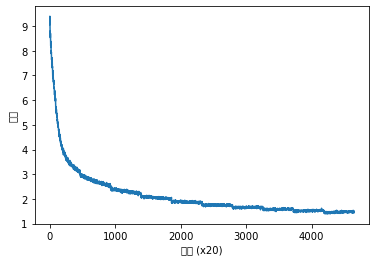

NameError: name 'word' is not defined

In [4]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target
import ptb
import pickle
import numpy as np

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [6]:
word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [7]:
from common.util import most_similar, analogy
import pickle

pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.70556640625
 they: 0.64599609375
 i: 0.6044921875
 someone: 0.447509765625
 people: 0.425048828125

[query] year
 month: 0.77587890625
 week: 0.74609375
 decade: 0.59716796875
 summer: 0.59130859375
 spring: 0.517578125

[query] car
 cars: 0.44189453125
 payouts: 0.38720703125
 attitude: 0.3681640625
 deaver: 0.361083984375
 auto: 0.357421875

[query] toyota
 al: 0.411865234375
 ford: 0.40380859375
 pipes: 0.39111328125
 single-a-2: 0.3837890625
 mci: 0.3740234375


In [8]:
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 thief: 4.2109375
 narcotics: 4.03125
 middlemen: 3.921875
 minds: 3.828125
 feeds: 3.57421875

[analogy] take:took = go:?
 writes: 3.845703125
 tilt: 3.8359375
 paterson: 3.669921875
 batibot: 3.51953125
 lesko: 3.4453125

[analogy] car:cars = child:?
 earthquake-related: 4.046875
 interbank: 3.9765625
 accustomed: 3.916015625
 bartlett: 3.806640625
 industrialized: 3.732421875

[analogy] good:better = bad:?
 citizen: 3.806640625
 khmer: 3.791015625
 narrowly: 3.603515625
 contemplating: 3.525390625
 counterparts: 3.279296875
